In [8]:
import requests
from bs4 import BeautifulSoup as bs
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
pendant = "https://www.rottentomatoes.com"

In [10]:
start_url = "https://www.rottentomatoes.com/top/"
start_content = requests.get(start_url)
start_soup = bs(start_content.text, "html.parser")

genre_url = []
genre_name = []
# get all genres moveis name and url
genre_list = start_soup.find_all("ul", {"class":"genrelist"} )
for genre in genre_list:
    for ele in genre.find_all("a", {"class":"articleLink unstyled"}):
        genre_url.append(pendant + ele["href"])
        genre_name.append(ele.get_text().replace("Top 100 ",""))

In [11]:
genre_box = []
cast_box = {}

for url, name in zip(genre_url, genre_name):
    box_sum = 0
    genre_content = requests.get(url)
    genre_soup = bs(genre_content.text, "html.parser")
    
    # find movies url in each genre
    movie_url = []
    for td in genre_soup.find_all("td"):
        for ele in td.find_all("a", {"class":"unstyled articleLink"}):
            #print(pendant + ele["href"])
            movie_url.append(pendant + ele["href"])
            
    # find cast and box each movie
    box_sum = 0 # box sum of this genre
    for url in movie_url:
        movie_content = requests.get(url)
        movie_soup = bs(movie_content.text, "html.parser")
        
        # find box
        box = 0
        for b in movie_soup.find_all("li", {"class":"meta-row clearfix"}):
            if "Box Office" in b.get_text():
                box = int(b.get_text().split("$")[-1].strip().replace(",", ""))
        
        # find cast and store it's box in cast_box
        # if box is 0, not need to find cast
        if(box != 0):
            box_sum += box
            for media in movie_soup.find_all("div", {"class":"media-body"}):
                for star in media.find_all("a", {"class", "unstyled articleLink"}):
                    cast = star.get_text().strip()
                    if cast not in cast_box:
                        cast_box[cast] = box
                    else:
                        cast_box[cast] += box
    genre_box.append(int(box_sum))

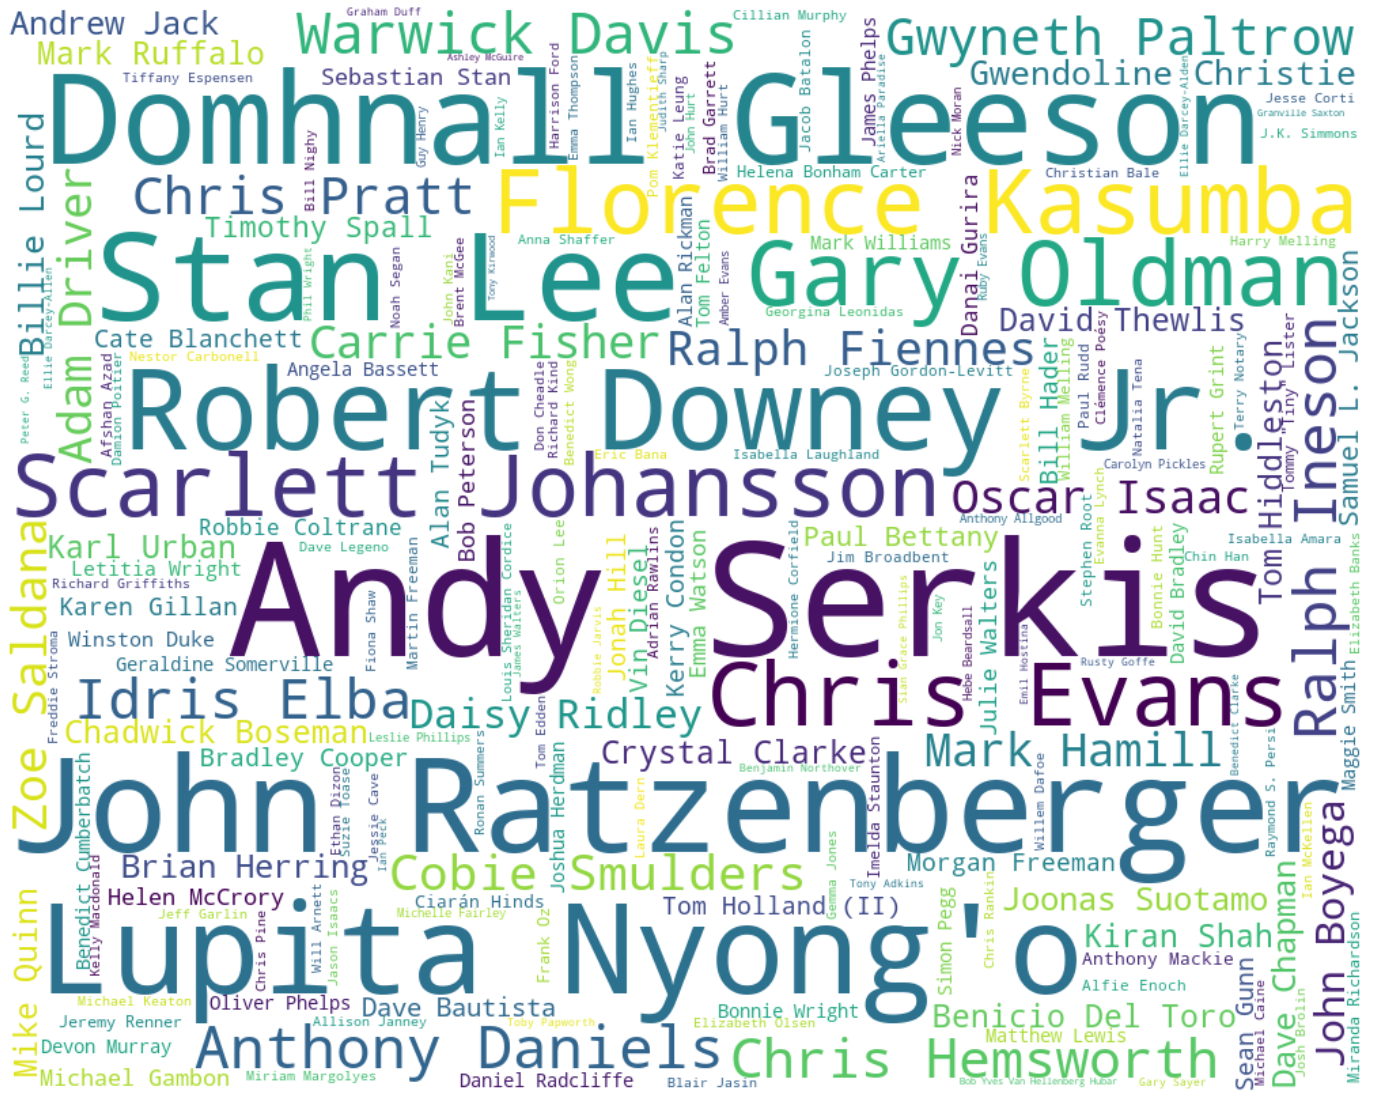

In [12]:
plt.figure(figsize = (30,20))
wordcloud = WordCloud(background_color = "white",width = 1000, height = 800,contour_width = 10,prefer_horizontal = 0.4,).generate_from_frequencies(cast_box)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

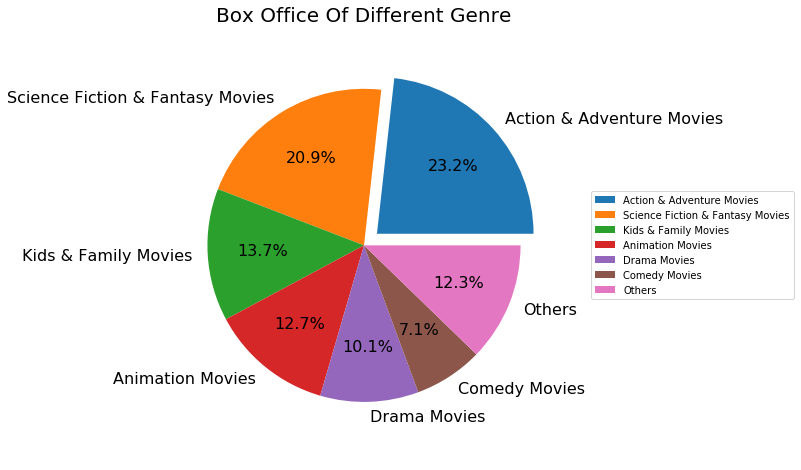

In [13]:
separate_num = 7
if(len(genre_box) < separate_num):
    separate_num = len(genre_box)

tempt = zip(genre_box, genre_name)
tempt = sorted(tempt, reverse = True)

# count total of others
total = 0
for i in range(separate_num, len(genre_box)):
    total += int(tempt[i][0])

tempt_box = []
tempt_name = []
# make data and label
for i in range(0, separate_num - 1):
    tempt_box.append(int(tempt[i][0]))
    tempt_name.append(str(tempt[i][1]))
tempt_box.append(total)
tempt_name.append("Others")

separate = []
# make separate
max_box_index = tempt_box.index(max(tempt_box))
for i in range(separate_num):
    if(i == max_box_index):
        separate.append(0.1)
    else:
        separate.append(0)
        
plt.figure(figsize=(12,8))
pictures,category_text,percent_text = plt.pie(tempt_box, 
                                              #colors = color, 
                                              labels = tempt_name, 
                                              autopct = "%0.1f%%", 
                                              explode = separate, 
                                              pctdistance = 0.65, 
                                              radius = 0.9, 
                                              #center = (0,-10), 
                                              textprops = {"fontsize" : 16},
                                              shadow = False)
plt.title("Box Office Of Different Genre", {"fontsize" : 20})
plt.legend(loc = "right", bbox_to_anchor=(1.5, 0.5))
plt.show()